In [3]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install hyperas

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1.1)


In [4]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

from hyperas.distributions import uniform



# ----------- TODO: Issues with importing imbalance-learn library
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import (RandomUnderSampler,
#                                      ClusterCentroids,
#                                      TomekLinks,
#                                      NeighbourhoodCleaningRule,
#                                      NearMiss)

Using TensorFlow backend.


In [5]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [6]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.severity/max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [7]:
def process_data(data, start_year, end_year, blockid_dict):

    X = np.zeros((len(blockid_dict), 24, 7))
    y = np.zeros((len(blockid_dict), 12, 7))
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            if r[1] == end_year:
                # index into array  0-based month
                # vvvvvvvvvvvvvvvv    vvvvvv
                y[blockid_dict[r[0]], r[2]-1, r[3]] = float(r[4])
                #                             ^^^^^^^^^^^^^   ^^^^
                #                             hours since     risk
                #                             beginning of
                #                             week
            else:
                # month, year = get_month_year(datetime)
                # index into array    year 0.....1   month   
                # vvvvvvvvvvvvvvvv    vvvvvvvvvvvvv  vvvvvv
                X[blockid_dict[r[0]], 12*(r[1]-start_year)+r[2]-1, r[3]] = float(r[4])
                #                                                  ^^^^^^^^^^^^^   ^^^^
                #                                                  hours since     risk
                #                                                  beginning of
                #                                                  week


    X = X * 1000
    y = y * 1000

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [8]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict)

    return X_train, X_test, y_train, y_test

In [9]:
%%time

# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 800

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


(800, 24, 7) (800, 12, 7) (800, 24, 7) (800, 12, 7)
CPU times: user 878 ms, sys: 107 ms, total: 985 ms
Wall time: 19.2 s


In [10]:
x_flat = X_test.flatten()
len(x_flat[x_flat > 0.0])

117552

In [11]:
len(x_flat[x_flat > 0.0])/len(x_flat)

0.8746428571428572

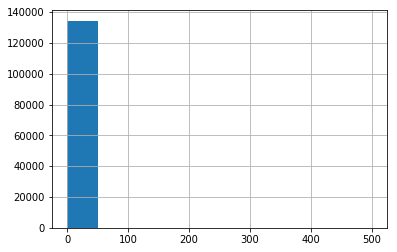

In [12]:
pd.Series(x_flat).hist();

In [13]:
pd.Series(x_flat).value_counts(normalize=True)

0.000000    0.125357
0.341880    0.000856
0.535906    0.000826
0.647249    0.000737
0.472144    0.000670
0.693001    0.000610
0.464253    0.000603
0.390549    0.000588
1.618123    0.000558
0.366300    0.000551
0.267953    0.000536
0.857633    0.000536
1.078749    0.000536
0.137826    0.000521
0.944287    0.000506
0.289352    0.000491
0.599520    0.000491
0.439754    0.000476
0.582751    0.000476
1.294498    0.000469
0.291121    0.000469
1.307190    0.000461
0.393082    0.000461
0.761035    0.000461
0.416146    0.000454
0.571755    0.000454
0.693481    0.000454
0.512821    0.000446
0.268168    0.000446
0.440335    0.000446
              ...   
0.365397    0.000007
2.822808    0.000007
2.910361    0.000007
3.273198    0.000007
6.080114    0.000007
3.518519    0.000007
1.366387    0.000007
3.062678    0.000007
5.591054    0.000007
0.248016    0.000007
2.448730    0.000007
3.949224    0.000007
1.026036    0.000007
1.848429    0.000007
2.464572    0.000007
6.082725    0.000007
8.547009    0

In [14]:
np.corrcoef(y_train.flatten(), y_test.flatten())

array([[1.        , 0.00173791],
       [0.00173791, 1.        ]])

In [15]:
X_train = X_train.reshape((800, 168))
y_train = y_train.reshape((800, 84))
X_test = X_test.reshape((800, 168))
y_test = y_test.reshape((800, 84))

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

model = MultiOutputRegressor(RandomForestRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch = GridSearchCV(model,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch.fit(X_train, y_train)

best_training_score = gridsearch.score(X_train, y_train)
best_testing_score  = gridsearch.score(X_test, y_test)
best_model_params = gridsearch.cv_results_['params'][gridsearch.best_index_]

print(f'  Best training score:', -best_training_score)
print(f'  Best testing score: ', -best_testing_score)
print('Best Grid Search model:', best_model_params)

y_pred = gridsearch.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-0.6058693799516381, total=  44.4s
[CV] ...................... , score=-0.5175043304111524, total=  44.5s
[CV] ...................... , score=-1.8189192667410214, total=  44.5s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   44.7s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   44.9s remaining:   44.9s


[CV] ....................... , score=-0.395287824311342, total=  44.8s
[CV] ...................... , score=-3.1149924964726106, total= 1.0min


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.0min remaining:   26.2s


[CV] ...................... , score=-0.5209965258185225, total= 1.0min
[CV] ..................... , score=-0.43909457423646586, total= 1.0min
[CV] ....................... , score=-74.81088252185566, total= 1.0min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished


  Best training score: 1.047272803309822
  Best testing score:  3.288385009451092
Best Grid Search model: {}
mean_squared_error: 3.288385009451092


In [17]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('Hour since beginning of data', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

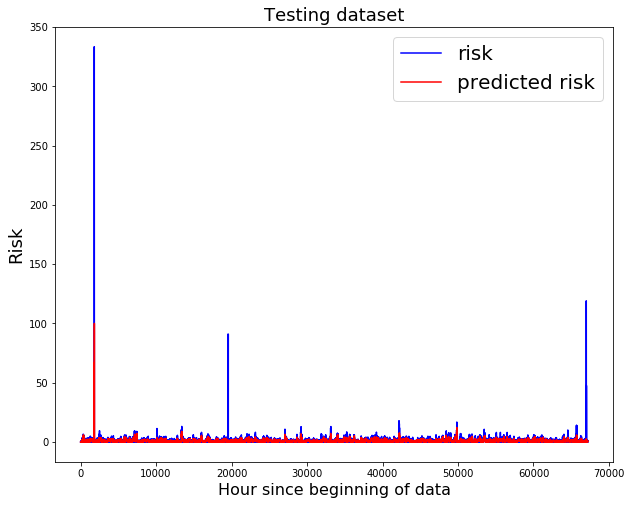

In [24]:
plot_output(y_test, y_pred, 'Testing')

In [19]:
!pip3 install xgboost
from xgboost import XGBRegressor


In [23]:
model2 = MultiOutputRegressor(XGBRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch2 = GridSearchCV(model2,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch2.fit(X_train, y_train)

best_training_score2 = gridsearch2.score(X_train, y_train)
best_testing_score2  = gridsearch2.score(X_test, y_test)
best_model_params2 = gridsearch2.cv_results_['params'][gridsearch2.best_index_]

print(f'  Best training score:', -best_training_score2)
print(f'  Best testing score: ', -best_testing_score2)
print('Best Grid Search model:', best_model_params2)

y_pred2 = gridsearch2.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred2))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

[CV] ....................... , score=-0.872850986000193, total= 1.2min


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV] ....................... , score=-0.394860157944709, total= 1.2min
[CV] ...................... , score=-0.5763988834482344, total= 1.2min


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.3min remainin

[CV] ....................... , score=-74.71784873185086, total= 1.3min


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

[CV] ...................... , score=-3.1348954776472637, total= 1.3min


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.3min remaining:  1.3min
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory con

[CV] ....................... , score=-0.520109028590009, total= 1.3min
[CV] ...................... , score=-0.5274410137792879, total= 1.3min


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.3min remaining:   33.7s
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory con

[CV] ...................... , score=-0.5777454974680379, total= 1.3min


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV] ...................... , score=-1.8061561090915539, total= 1.4min


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[CV] ...................... , score=-0.4456072321784484, total= 1.4min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packag

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


  Best training score: 0.06716190505685644
  Best testing score:  3.009236170111257
Best Grid Search model: {}
mean_squared_error: 3.009236170111257


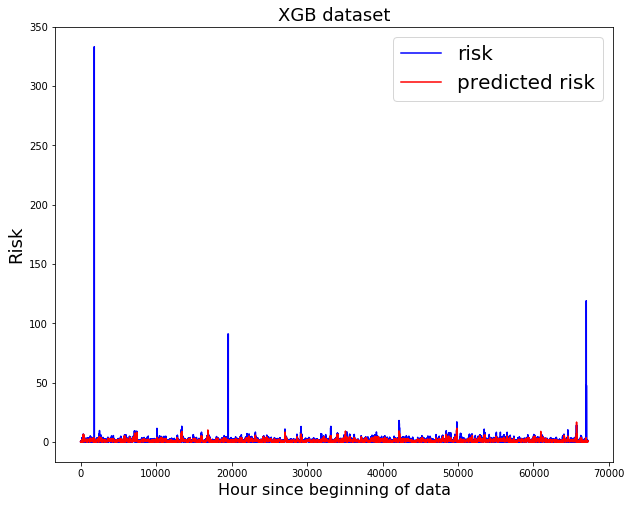

In [25]:
plot_output(y_test, y_pred2, 'XGB')

In [27]:
from sklearn.linear_model import LinearRegression

In [29]:
model3 = MultiOutputRegressor(LinearRegression())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch3 = GridSearchCV(model3,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch3.fit(X_train, y_train)

best_training_score3 = gridsearch3.score(X_train, y_train)
best_testing_score3  = gridsearch3.score(X_test, y_test)
best_model_params3 = gridsearch3.cv_results_['params'][gridsearch3.best_index_]

print(f'  Best training score:', -best_training_score3)
print(f'  Best testing score: ', -best_testing_score3)
print('Best Grid Search model:', best_model_params3)

y_pred3 = gridsearch3.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred3))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-0.8083425225370817, total=   6.4s
[CV] ...................... , score=-1.1185467218699858, total=   6.4s
[CV] ...................... , score=-0.7312025157133926, total=   6.7s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    9.4s remaining:   21.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    9.5s remaining:    9.5s


[CV] ...................... , score=-0.6298967209113571, total=   7.3s
[CV] ...................... , score=-3.3285404672630072, total=   7.6s


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    9.8s remaining:    4.2s


[CV] ...................... , score=-0.7429909343287012, total=   8.7s
[CV] ...................... , score=-0.9027759962440605, total=   8.7s
[CV] ...................... , score=-0.5909982389272427, total=   9.6s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.2s finished


  Best training score: 0.23886599494775745
  Best testing score:  8.46538139963866
Best Grid Search model: {}
mean_squared_error: 8.46538139963866


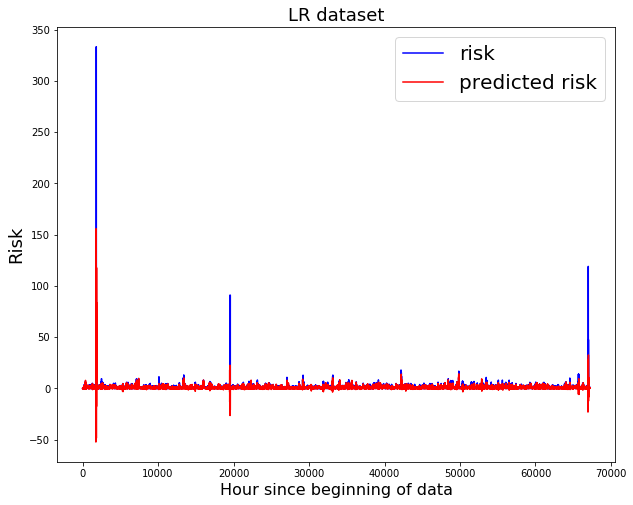

In [30]:
plot_output(y_test, y_pred3, 'LR')

In [31]:
from sklearn.linear_model import Ridge

In [32]:
model4 = MultiOutputRegressor(Ridge())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch4 = GridSearchCV(model4,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch4.fit(X_train, y_train)

best_training_score4 = gridsearch4.score(X_train, y_train)
best_testing_score4  = gridsearch4.score(X_test, y_test)
best_model_params4 = gridsearch4.cv_results_['params'][gridsearch4.best_index_]

print(f'  Best training score:', -best_training_score4)
print(f'  Best testing score: ', -best_testing_score4)
print('Best Grid Search model:', best_model_params4)

y_pred4 = gridsearch4.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred4))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-0.7379999706219147, total=   3.4s
[CV] ...................... , score=-0.8958467522637599, total=   3.4s
[CV] ...................... , score=-0.5869988007971154, total=   3.4s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


  Best training score: 0.23887197319248252
  Best testing score:  8.407253857688136
Best Grid Search model: {}
mean_squared_error: 8.407253857688136


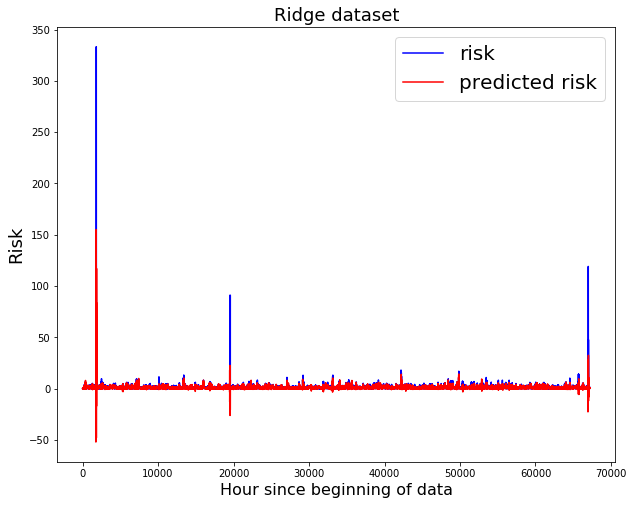

In [33]:
plot_output(y_test, y_pred4, 'Ridge')

In [42]:
from sklearn import linear_model

In [46]:
model5 = MultiOutputRegressor(linear_model.Lasso())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch5 = GridSearchCV(model5,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch5.fit(X_train, y_train)

best_training_score5 = gridsearch5.score(X_train, y_train)
best_testing_score5  = gridsearch5.score(X_test, y_test)
best_model_params5 = gridsearch5.cv_results_['params'][gridsearch5.best_index_]

print(f'  Best training score:', -best_training_score5)
print(f'  Best testing score: ', -best_testing_score5)
print('Best Grid Search model:', best_model_params5)

y_pred5 = gridsearch5.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred5))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=-2.009950107879789, total=   0.4s
[CV] ........................ , score=-74.8507738776508, total=   0.4s
[CV] ...................... , score=-0.8859858881829613, total=   0.5s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s


[CV] ....................... , score=-4.028431785331494, total=   0.9s
[CV] ...................... , score=-1.0132068309728137, total=   0.9s
[CV] ....................... , score=-1.027819010035009, total=   1.0s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


  Best training score: 1.0253633753154343
  Best testing score:  3.525948515547118
Best Grid Search model: {}
mean_squared_error: 3.525948515547118


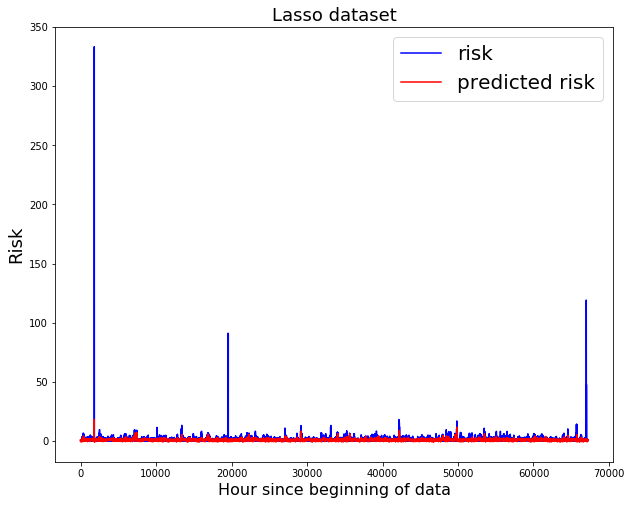

In [44]:
plot_output(y_test, y_pred5, 'Lasso')

In [47]:
from sklearn.linear_model import ElasticNet

In [48]:
model6 = MultiOutputRegressor(linear_model.ElasticNet())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch6 = GridSearchCV(model6,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch6.fit(X_train, y_train)

best_training_score6 = gridsearch6.score(X_train, y_train)
best_testing_score6  = gridsearch6.score(X_test, y_test)
best_model_params6 = gridsearch6.cv_results_['params'][gridsearch6.best_index_]

print(f'  Best training score:', -best_training_score6)
print(f'  Best testing score: ', -best_testing_score6)
print('Best Grid Search model:', best_model_params6)

y_pred6 = gridsearch6.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred6))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=-1.290748032646965, total=   0.5s
[CV] ...................... , score=-0.5256937514285039, total=   0.6s
[CV] ...................... , score=-0.7214646421317237, total=   0.6s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.0s remaining:    1.0s


[CV] ...................... , score=-3.5562977092349954, total=   1.1s
[CV] ...................... , score=-0.6565640150485506, total=   1.1s
[CV] ...................... , score=-0.8141212926369006, total=   1.2s
[CV] ...................... , score=-0.7325572435770332, total=   1.2s
[CV] ...................... , score=-0.6155904451630286, total=   1.3s


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


  Best training score: 0.688241860584843
  Best testing score:  3.2521479462715903
Best Grid Search model: {}
mean_squared_error: 3.2521479462715903


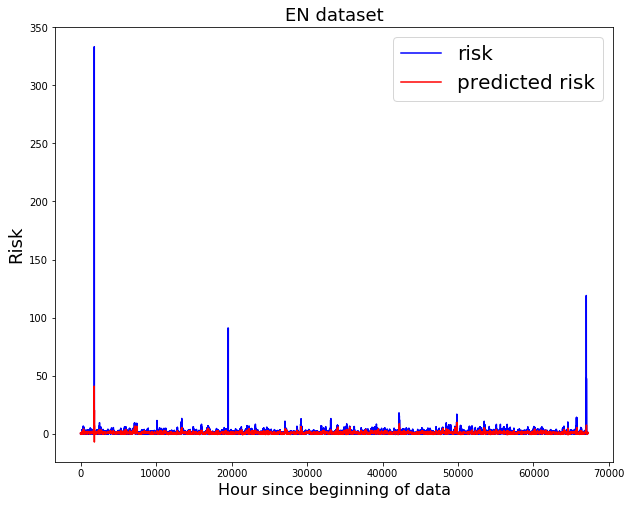

In [49]:
plot_output(y_test, y_pred6, 'EN')

In [53]:
model7 = MultiOutputRegressor(linear_model.LassoLars())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch7 = GridSearchCV(model7,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch7.fit(X_train, y_train)

best_training_score7 = gridsearch7.score(X_train, y_train)
best_testing_score7  = gridsearch7.score(X_test, y_test)
best_model_params7 = gridsearch7.cv_results_['params'][gridsearch7.best_index_]

print(f'  Best training score:', -best_training_score7)
print(f'  Best testing score: ', -best_testing_score7)
print('Best Grid Search model:', best_model_params7)

y_pred7 = gridsearch7.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred7))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-0.7924885639421791, total=   2.9s
[CV] ...................... , score=-0.9519556601449958, total=   3.1s
[CV] ....................... , score=-74.88771798213845, total=   3.1s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    3.4s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.6s remaining:    1.5s


[CV] ...................... , score=-1.0605122450613123, total=   3.4s
[CV] ...................... , score=-1.0952753152134522, total=   3.4s
[CV] ........................ , score=-3.98545891478653, total=   3.5s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


  Best training score: 8.85521618349918
  Best testing score:  3.5923860622572485
Best Grid Search model: {}
mean_squared_error: 3.5923860622572485


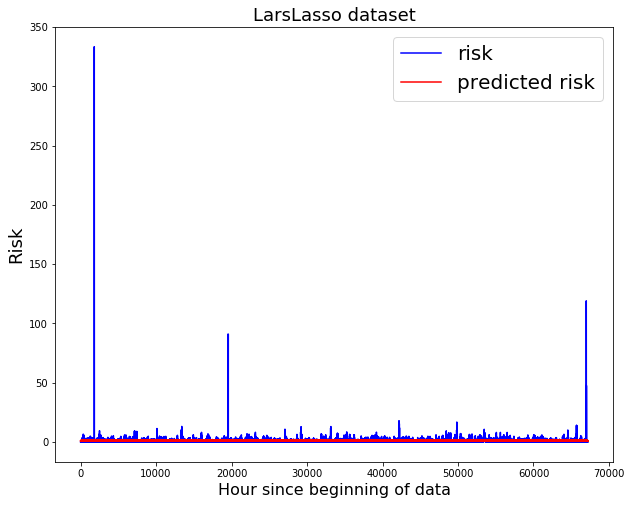

In [54]:
plot_output(y_test, y_pred7, 'LarsLasso')

In [55]:
model8 = MultiOutputRegressor(linear_model.BayesianRidge())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch8 = GridSearchCV(model8,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch8.fit(X_train, y_train)

best_training_score8 = gridsearch8.score(X_train, y_train)
best_testing_score8  = gridsearch8.score(X_test, y_test)
best_model_params8 = gridsearch8.cv_results_['params'][gridsearch8.best_index_]

print(f'  Best training score:', -best_training_score8)
print(f'  Best testing score: ', -best_testing_score8)
print('Best Grid Search model:', best_model_params8)

y_pred8 = gridsearch8.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred8))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ..................... , score=-0.44330309229960235, total=  16.1s
[CV] ..................... , score=-0.48108086997293226, total=  16.2s
[CV] ...................... , score=-2.8304691191429154, total=  16.5s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   16.7s remaining:   39.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   16.8s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   16.9s remaining:    7.2s


[CV] ...................... , score=-0.6119250369669592, total=  16.7s
[CV] ...................... , score=-0.6373064999956612, total=  16.8s
[CV] ...................... , score=-0.5568398851114454, total=  16.9s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.0s finished


  Best training score: 0.26165559519600917
  Best testing score:  5.46663857741692
Best Grid Search model: {}
mean_squared_error: 5.46663857741692


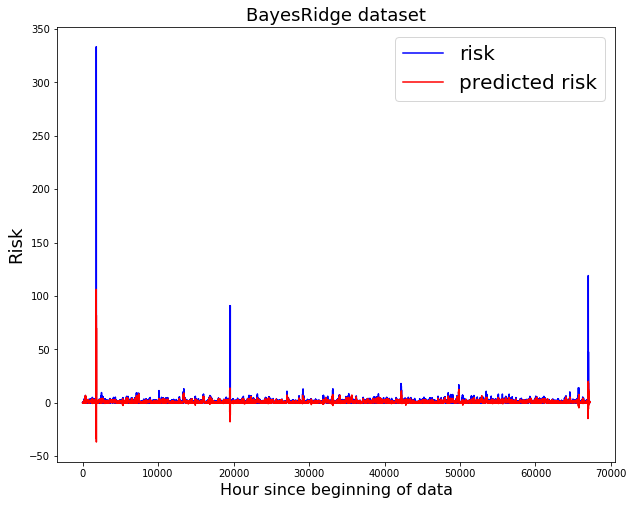

In [56]:
plot_output(y_test, y_pred8, 'BayesRidge')

In [64]:
from sklearn.linear_model import HuberRegressor

In [78]:
model9 = MultiOutputRegressor(HuberRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch9 = GridSearchCV(model9,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch9.fit(X_train, y_train)

best_training_score9 = gridsearch9.score(X_train, y_train)
best_testing_score9  = gridsearch9.score(X_test, y_test)
best_model_params9 = gridsearch9.cv_results_['params'][gridsearch9.best_index_]

print(f'  Best training score:', -best_training_score9)
print(f'  Best testing score: ', -best_testing_score9)
print('Best Grid Search model:', best_model_params9)

y_pred9 = gridsearch9.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred9))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-0.6827619001865166, total= 1.1min
[CV] ...................... , score=-0.7256016531611783, total= 1.2min
[CV] ...................... , score=-0.5821249945996423, total= 1.2min


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.2min remaining:  2.7min


[CV] ...................... , score=-0.8263596746344019, total= 1.2min
[CV] ....................... , score=-3.629107522813397, total= 1.2min


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.2min remaining:  1.2min


[CV] ...................... , score=-0.5394360670557702, total= 1.2min
[CV] ....................... , score=-88.26228568782786, total= 1.2min


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.2min remaining:   31.4s


[CV] ...................... , score=-1.0457820098979909, total= 1.2min
[CV] ...................... , score=-0.6921006395945466, total= 1.2min
[CV] ...................... , score=-3.2713692570358934, total= 1.2min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


  Best training score: 0.28157685676970934
  Best testing score:  7.4870669539186645
Best Grid Search model: {}
mean_squared_error: 7.4870669539186645


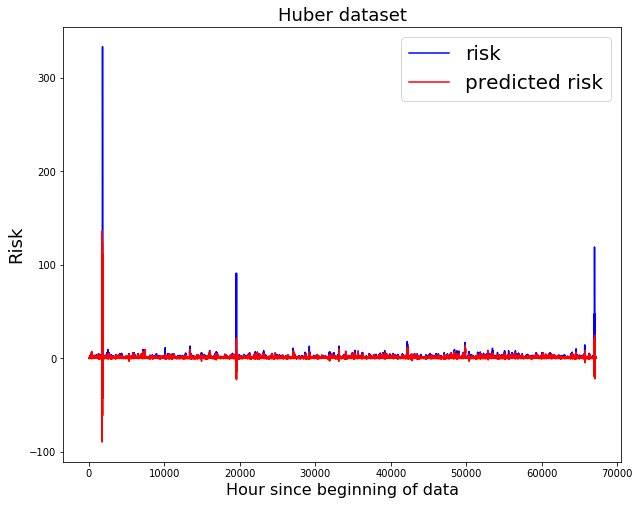

In [79]:
plot_output(y_test, y_pred9, 'Huber')

In [59]:
from sklearn.tree import DecisionTreeRegressor

In [61]:
model10 = MultiOutputRegressor(DecisionTreeRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch10 = GridSearchCV(model10,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch10.fit(X_train, y_train)

best_training_score10 = gridsearch10.score(X_train, y_train)
best_testing_score10  = gridsearch10.score(X_test, y_test)
best_model_params10 = gridsearch10.cv_results_['params'][gridsearch10.best_index_]

print(f'  Best training score:', -best_training_score10)
print(f'  Best testing score: ', -best_testing_score10)
print('Best Grid Search model:', best_model_params10)

y_pred10 = gridsearch10.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred10))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-3.5191290606565766, total=   7.7s
[CV] ...................... , score=-2.0998604434797774, total=   7.8s
[CV] ...................... , score=-1.4548835651006204, total=   7.8s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    7.9s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.0s remaining:    8.0s


[CV] ...................... , score=-1.0352805859537941, total=  10.7s
[CV] ...................... , score=-0.9746941772091753, total=  10.7s
[CV] ...................... , score=-0.7792148410862768, total=  10.8s
[CV] ....................... , score=-75.93769034700382, total=  10.8s


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   10.8s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.9s finished


  Best training score: 4.27312411290598e-10
  Best testing score:  9.220703839130035
Best Grid Search model: {}
mean_squared_error: 9.220703839130035


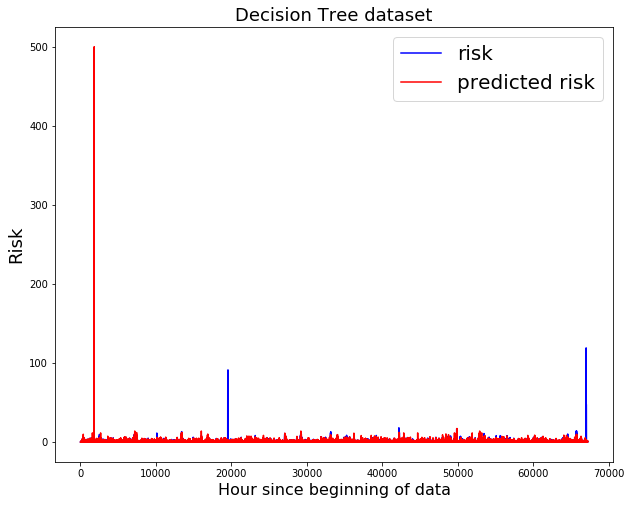

In [62]:
plot_output(y_test, y_pred10, 'Decision Tree')

In [66]:
from sklearn.neighbors import KNeighborsRegressor

In [67]:
model11 = MultiOutputRegressor(KNeighborsRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch11 = GridSearchCV(model11,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch11.fit(X_train, y_train)

best_training_score11 = gridsearch11.score(X_train, y_train)
best_testing_score11  = gridsearch11.score(X_test, y_test)
best_model_params11 = gridsearch11.cv_results_['params'][gridsearch11.best_index_]

print(f'  Best training score:', -best_training_score11)
print(f'  Best testing score: ', -best_testing_score11)
print('Best Grid Search model:', best_model_params11)

y_pred11 = gridsearch11.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred11))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ........................ , score=-3.07725409322725, total=   1.6s
[CV] ..................... , score=-0.48553203324947264, total=   1.6s
[CV] ...................... , score=-0.8848961851480016, total=   1.7s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   14.3s remaining:   33.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   14.5s remaining:   14.5s


[CV] ...................... , score=-0.5266106064716579, total=   2.4s
[CV] ....................... , score=-0.519186114049804, total=   2.4s
[CV] ...................... , score=-1.7376085770229839, total=   2.5s


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   18.8s remaining:    8.1s


[CV] ...................... , score=-0.3864951309046364, total=   2.5s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.1s finished


  Best training score: 5.279920757376705
  Best testing score:  2.9605573563021834
Best Grid Search model: {}
mean_squared_error: 2.9605573563021834


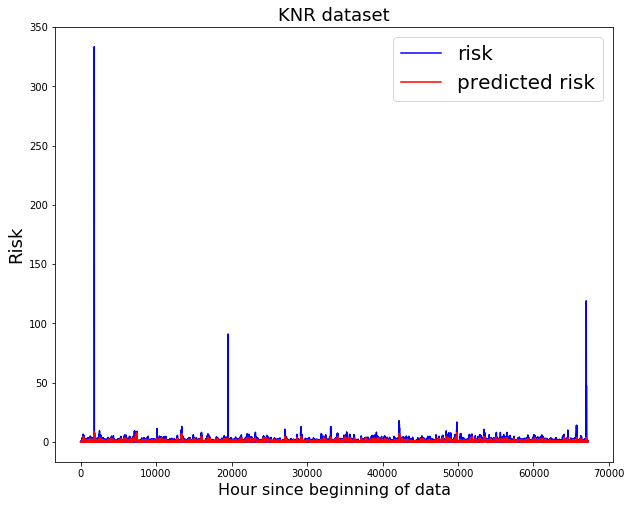

In [68]:
plot_output(y_test, y_pred11, 'KNR')

In [69]:
from sklearn.svm import LinearSVR

In [70]:
model12 = MultiOutputRegressor(LinearSVR())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch12 = GridSearchCV(model12,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch12.fit(X_train, y_train)

best_training_score12 = gridsearch12.score(X_train, y_train)
best_testing_score12  = gridsearch12.score(X_test, y_test)
best_model_params12 = gridsearch12.cv_results_['params'][gridsearch12.best_index_]

print(f'  Best training score:', -best_training_score12)
print(f'  Best testing score: ', -best_testing_score12)
print('Best Grid Search model:', best_model_params12)

y_pred12 = gridsearch12.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred12))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-0.7719623128481966, total=  20.5s
[CV] ...................... , score=-0.6085517382758214, total=  20.4s
[CV] ....................... , score=-3.610347329746343, total=  20.7s
[CV] ...........

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   20.8s remaining:   48.6s


[CV] ...................... , score=-1.1421176400755557, total=  21.1s


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   21.3s remaining:   21.3s


[CV] ...................... , score=-0.6546005036849343, total=  21.4s
[CV] ...................... , score=-0.9530370764532757, total=  28.0s


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   28.1s remaining:   12.1s


[CV] ....................... , score=-88.25273527470188, total=  28.3s
[CV] ...................... , score=-3.4360928185317516, total=  28.5s
[CV] ...................... , score=-0.7701571382953893, total=  28.8s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.9s finished


  Best training score: 0.3815023625173813
  Best testing score:  8.601477398318107
Best Grid Search model: {}
mean_squared_error: 8.601477398318107


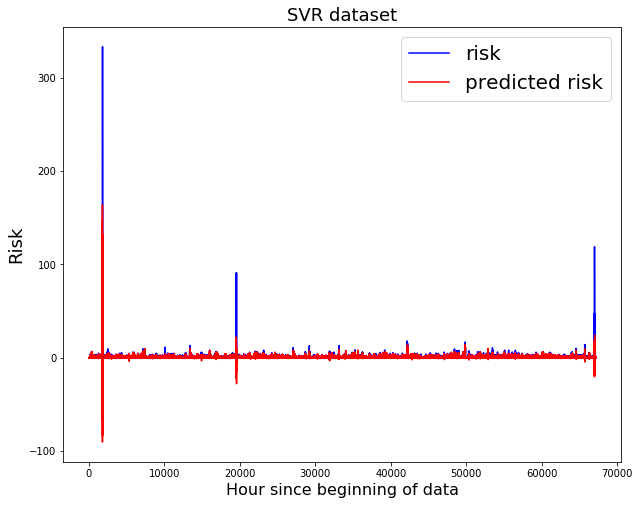

In [71]:
plot_output(y_test, y_pred12, 'SVR')

In [73]:
from sklearn.linear_model import SGDRegressor

In [74]:
model13 = MultiOutputRegressor(SGDRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch13 = GridSearchCV(model13,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch13.fit(X_train, y_train)

best_training_score13 = gridsearch13.score(X_train, y_train)
best_testing_score13  = gridsearch13.score(X_test, y_test)
best_model_params13 = gridsearch13.cv_results_['params'][gridsearch13.best_index_]

print(f'  Best training score:', -best_training_score13)
print(f'  Best testing score: ', -best_testing_score13)
print('Best Grid Search model:', best_model_params13)

y_pred13 = gridsearch13.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred13))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

[CV]  ................................................................
[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

[CV]  ................................................................
[CV]  ................................................................


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

[CV] .................... , score=-2.88761892613946e+23, total=   0.6s
[CV] .................. , score=-4.5002310267935594e+23, total=   0.6s
[CV] .................... , score=-8.53922221265244e+23, total=   0.6s
[CV] .................. , score=-2.5217285885465863e+23, total=   0.6s
[CV] ................... , score=-3.839556456117494e+23, total=   0.6s
[CV] .................. , score=-4.1543304447445625e+23, total=   0.6s
[CV] ................... , score=-2.176975942443167e+24, total=   0.7s
[CV] .................. , score=-2.8283388130419167e+23, total=   0.7s
[CV] ................... , score=-3.059942525447931e+23, total=   0.7s
[CV] .................. , score=-2.8406809741520237e+21, total=   0.8s


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have bee

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

  Best training score: 1.1138024991122211e+26
  Best testing score:  8.801730324599306e+23
Best Grid Search model: {}
mean_squared_error: 8.801730324599306e+23


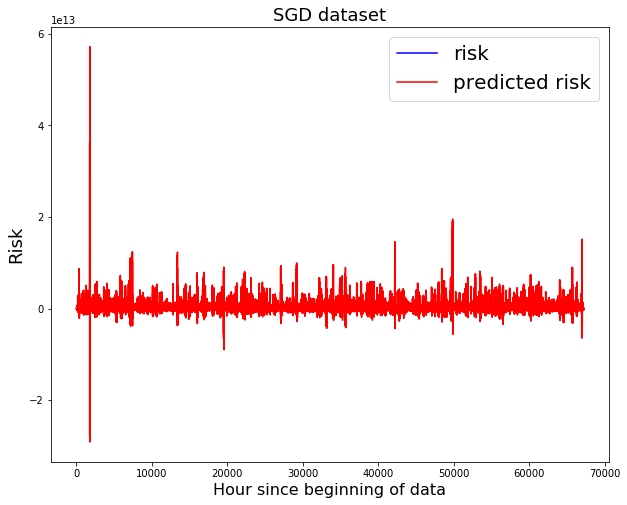

In [75]:
plot_output(y_test, y_pred13, 'SGD')

In [80]:
from sklearn.linear_model import RANSACRegressor

In [81]:
model14 = MultiOutputRegressor(RANSACRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch14 = GridSearchCV(model14,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=10, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch14.fit(X_train, y_train)

best_training_score14 = gridsearch14.score(X_train, y_train)
best_testing_score14  = gridsearch14.score(X_test, y_test)
best_model_params14 = gridsearch14.cv_results_['params'][gridsearch14.best_index_]

print(f'  Best training score:', -best_training_score14)
print(f'  Best testing score: ', -best_testing_score14)
print('Best Grid Search model:', best_model_params14)

y_pred14 = gridsearch14.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred14))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


Process ForkPoolWorker-380:
Process ForkPoolWorker-384:
Process ForkPoolWorker-379:
Process ForkPoolWorker-383:
Process ForkPoolWorker-382:
Process ForkPoolWorker-381:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing

KeyboardInterrupt: 

In [ ]:
plot_output(y_test, y_pred14, 'RANSAC')